In [1]:
#The following code is from Andrew Ng
import os
import numpy as np
import tensorflow as tf
import h5py
import math
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1)

In [2]:
def identityBlock(X, fSize, channels, stage, block):
    """Making a resnet layer consisting of (Conv2D(1x1)->BN->Relu)-> (Conv2D (fxf)->BN->Relu)->(Conv2D(1x1)->BN->ResNet Relu)
    
    Arguments:
    X = tensor in shape of (m, nH0, nW0, nC0)
    f = the size of the filter used for the second Conv2D
    channels = list of three elements, each with integer to define the number of channel output of A1, A2, A3
    stage = integer, the current place of the current resBlock (horizontally)
    block = string, the current place of the current resBlock (vertically)
    
    Output:
    x = Tensor of Shape (nH,nW,nC)"""
    assert len(channels) == 3
    convNameBase = "res"+str(stage)+block+"_branch"
    bnNameBase = "bn"+str(stage)+block+"_branch"
    X_shortcut = X
    #first layer
    X = Conv2D(channels[0], (1,1), strides = (1,1), name = convNameBase + "2a", padding = "valid", kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bnNameBase + "2a")(X)
    X = Activation("relu")(X)
    #second layer
    X = Conv2D(channels[1], (fSize,fSize), strides = (1,1), name = convNameBase + "2b", padding = "same", kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bnNameBase + "2b")(X)
    X = Activation("relu")(X)
    #last layer
    X = Conv2D(channels[2], (1,1), strides = (1,1), name = convNameBase + "2c", padding = "same", kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bnNameBase + "2c")(X)
    """WARNING!: Make sure that the number of the channel of X and X_shortcut is the same!"""
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)
    return X

In [3]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identityBlock(A_prev, 2, [2, 4, 6], 1, 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.19716814 0.         1.3561227  2.1713073  0.         1.3324987 ]


In [4]:
def convolutionBlock(X, fSize, channels, stage, block, s = 2):
    """Create a resnet block, but this time it will do Conv2D and BatchNorm to make sure that the size of the X_shortcut and X is the same dimension (H,W,channel)
    
    Argument:
    X = tensor in shape of (m,nH0,nW0, nC0)
    fSize = filter to be used for the second convolution
    channels = a list of 3 integer, used for defining the number of channels for A1, A2, A3
    stage = integer, the current place of the current resBlock (horizontally)
    block = string, the current place of the current resBlock (vertically)
    s = stride for the first layer 
    
    Output:
    X = tensor in shape of (nH, nW, nC) that has been applied with the resnet"""
    
    assert len(channels) == 3
    X_shortcut = X
    convNameBase = "res" + str(stage) + block + "_branch"
    bnNameBase = "bn" + str(stage) + block + "_branch"
    #First layer
    X = Conv2D(channels[0], (1,1), strides = (s,s), padding = "valid", name = convNameBase + "2a", kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bnNameBase + "2a")(X)
    X = Activation("relu")(X)
    
    #Second layer
    X = Conv2D(channels[1], (fSize,fSize), strides = (1,1), padding = "same", name = convNameBase + "2b", kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bnNameBase + "2b")(X)
    X = Activation("relu")(X)
    
    #Shortcut layer
    X_shortcut = Conv2D(channels[2], (1,1), strides = (s,s), padding = "valid", name = convNameBase + "1", kernel_initializer = glorot_uniform(seed = 0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bnNameBase + "1")(X_shortcut)
    
    #Final layer
    X = Conv2D(channels[2], (1,1), strides = (1,1), padding = "valid", name = convNameBase + "2c", kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bnNameBase + "2c")(X)
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)
    
    return X

In [5]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutionBlock(A_prev, 2, [2, 4, 6], 1, 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.09018459 1.2348977  0.46822017 0.03671761 0.         0.65516603]


In [6]:
def ResNet50(inputShape, classes):
    """Create our own implementation of the Famous ResNet50. The layers will be as follows:
    Stage0: ZeroPad with (3,3)
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER(FLATTEN + FC(DENSE))
    
    Arguments:
    inputShape = (nH,nW,nC) of the input
    classes = the number of the prediction result classes (using softmax)
    
    Output:
    model = Model() Keras' instance"""
    
    X_input = Input(inputShape)
    
    X = ZeroPadding2D((3,3))(X_input)
    X = Conv2D(64, (7,7), strides = (2,2), name = "conv1", kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = "bn_conv1")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D((3,3), strides = (2,2))(X)
    X = convolutionBlock(X, 3, [64,64,256],2, "a", 1)
    X = identityBlock(X, 3, [64,64,256],2, "b")
    X = identityBlock(X, 3, [64,64,256],2, "c")
    X = convolutionBlock(X, 3, [128,128,512],3, "a", 2)
    X = identityBlock(X, 3, [128,128,512],3, "b")
    X = identityBlock(X, 3, [128,128,512],3, "c")
    X = identityBlock(X, 3, [128,128,512],3, "d")
    X = convolutionBlock(X, 3, [256,256,1024],4, "a", 2)
    X = identityBlock(X, 3, [256,256,1024],4, "b")
    X = identityBlock(X, 3, [256,256,1024],4, "c")
    X = identityBlock(X, 3, [256,256,1024],4, "d")
    X = identityBlock(X, 3, [256,256,1024],4, "e")
    X = identityBlock(X, 3, [256,256,1024],4, "f")
    X = convolutionBlock(X, 3, [512,512,2048],5, "a", 2)
    X = identityBlock(X, 3, [512,512,2048],5, "b")
    X = identityBlock(X, 3, [512,512,2048],5, "c")
    X = AveragePooling2D((2,2), name = "avg_pool")(X)
    X = Flatten()(X)
    X = Dense(classes, activation = "softmax", name = "fc" + str(classes), kernel_initializer = glorot_uniform(seed = 0))(X)
    
    
    #Creating the model
    model = Model(inputs = X_input, outputs = X, name = "ResNet50")
    return model

In [7]:
model = ResNet50((64, 64, 3), 6)

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
#This code is from Andrew Ng Website
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices, since we use .T, now it is in shape of (datapoints, category)
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [10]:
model.fit(X_train, Y_train, epochs = 22, batch_size = 32)


Epoch 1/22
1080/1080 [==============================] - 159s 148ms/step - loss: 1.8992 - accuracy: 0.5065
Epoch 2/22
1080/1080 [==============================] - 155s 143ms/step - loss: 0.8893 - accuracy: 0.7889
Epoch 3/22
1080/1080 [==============================] - 133s 123ms/step - loss: 0.7656 - accuracy: 0.7583
Epoch 4/22
1080/1080 [==============================] - 149s 138ms/step - loss: 0.4908 - accuracy: 0.9019
Epoch 5/22
1080/1080 [==============================] - 151s 140ms/step - loss: 0.3264 - accuracy: 0.9130
Epoch 6/22
1080/1080 [==============================] - 152s 140ms/step - loss: 0.3691 - accuracy: 0.9278
Epoch 7/22
1080/1080 [==============================] - 151s 140ms/step - loss: 0.3708 - accuracy: 0.9120
Epoch 8/22
1080/1080 [==============================] - 124s 115ms/step - loss: 0.2568 - accuracy: 0.9120
Epoch 9/22
1080/1080 [==============================] - 149s 138ms/step - loss: 0.1494 - accuracy: 0.9491
Epoch 10/22
1080/1080 [======================

In [11]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 4s 33ms/step
Loss = 0.619579533735911
Test Accuracy = 0.8083333373069763


In [13]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

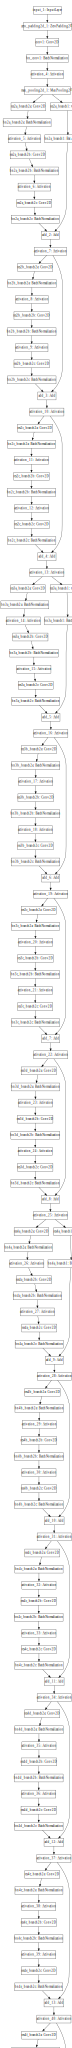

In [14]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))